# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$

$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0}$$

$$ y_{i} \in \{-1, 1\}$$

where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        return 1/(1+np.exp(-X @ weights))
    
    def get_loss(self, X_ext, y):
    #    X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        return np.sum(np.log(1+np.exp(-(X_ext @ self.weights_)*y)))/len(y)+(1/(2*self.C))*(np.sum(np.abs(self.weights_)**2))
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        self.loss_history = []
        for i in range(self.max_iter):
            self.loss_history.append(self.get_loss(X_ext, y))
            delta = np.sum(
                X_ext*y[:, None]*(1-1/(1+np.exp(-(X_ext @ self.weights_)*y))[:, None]), axis=0)/len(y)-(1/self.C)*self.weights_
            self.weights_ += self.eta * delta
            if np.linalg.norm(self.eta * delta) < self.tol:
                break
        
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return (self.predict_proba(X) > 0.5) * 2 - 1


In [5]:
from sklearn import datasets
from sklearn import metrics

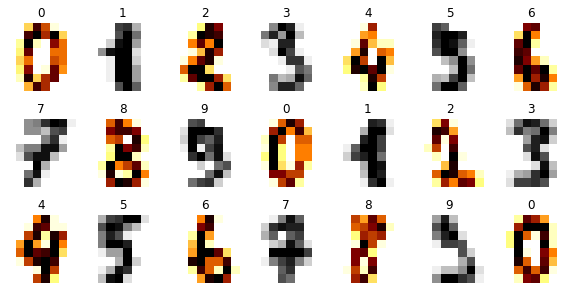

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

C:\Users\slobbery.GBAS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


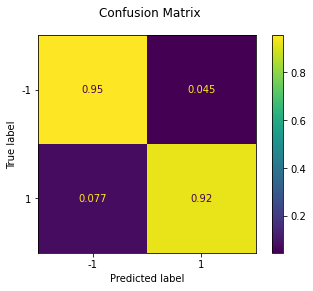

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

In [18]:
def plot_loss_graph_lr(models_arr, xlabel='Iteration', ylabel='Loss', title='Loss history'):
    plt.figure(figsize=(18, 9))
    for model in models_arr:
        plt.plot(range(len(model.loss_history)),
                 model.loss_history, label=f'Lr={model.eta}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()


**(0.5 points)** Visualize the loss history.

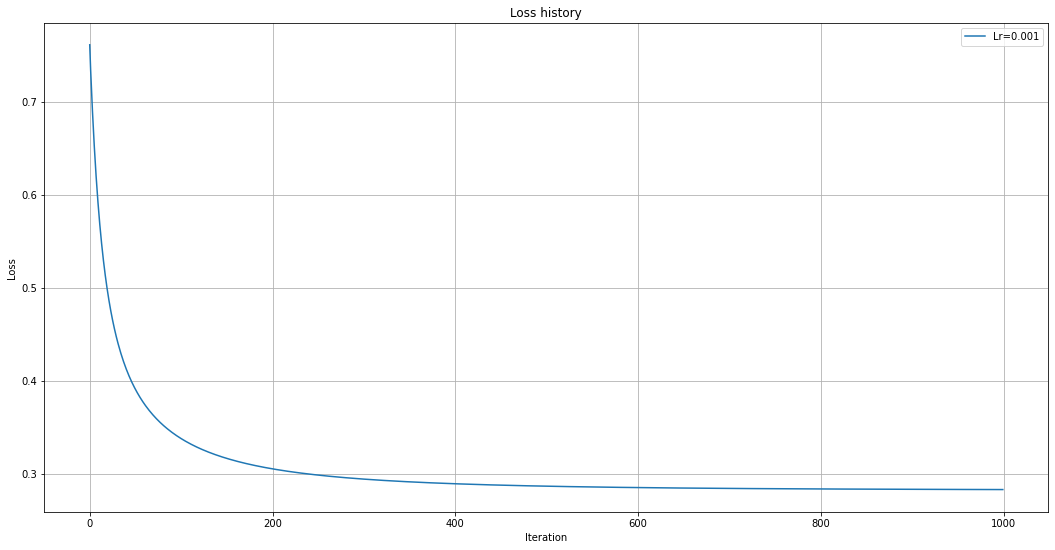

In [19]:
plot_loss_graph_lr([model])


**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

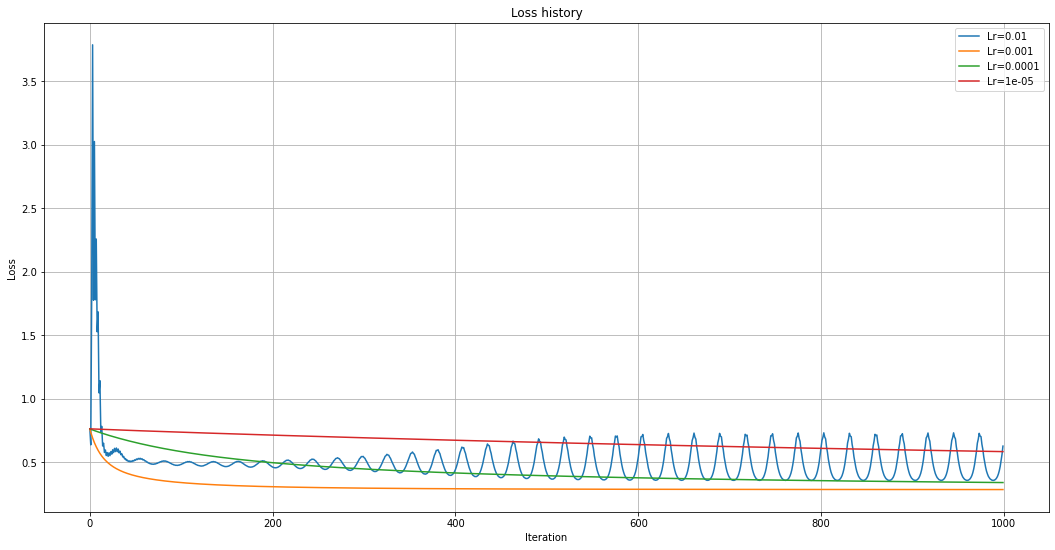

In [20]:
l_rates = [0.01, 0.001, 0.0001, 0.00001]
models = [CustomLogisticRegression(eta=lr) for lr in l_rates]
for model in models:
    model.fit(X_train, y_train)
plot_loss_graph_lr(models)


Из графика видно что при больших значениях eta(learning rate) процесс нахождения коэффициентов через регрессию принимает колебательный характер за счет того, что при большом learning rate при каждой итерации возле минимума при заданном tol модель проскакивает минимум и на следующем шаге пытается выернуться назад. При совсем малых значениях learning rate процесс нахождения минимума просто становиться долгим за счет очень маленького шага на каждой итерации. Тоесть если оставить learning rate 0,00001 то для достижения значения loss как при learning rate 0,001 просто надо больше чем 1000 итераций.
И если посчитать точность модели для eta=0.01 то видно что она мала.

C:\Users\slobbery.GBAS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


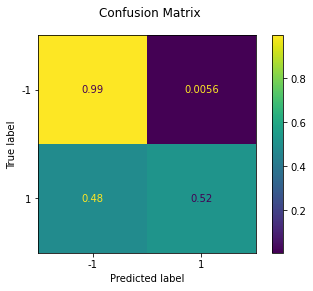

(0.7731384829505915, 0.7527777777777778)

In [21]:
train_acc, test_acc = fit_evaluate(CustomLogisticRegression(
    eta=0.01), X_train, y_train, X_test, y_test)
train_acc, test_acc


**(0.5 points)** Try different regularization parameter values and compare the model quality.

Согласно данным нам математическим формулам для CustomLogisticRegression параметром корректировки регуляризации является С. и согласно описания в классе чем менье его значение тем сильнее сходимость, тоесть меньше значение функции потерь. Из анализа предыдущих графиков зафиксируем eta = 0.001. так как при этом значении Loss наискорейшим образом достигает минимума в пределах заданных ограничений в 1000 циклов. А значание С будем менять.

In [22]:
def plot_loss_graph_с(models_arr, xlabel='Iteration', ylabel='Loss', title='Loss history'):
    plt.figure(figsize=(18, 9))
    for model in models_arr:
        plt.plot(range(len(model.loss_history)),
                 model.loss_history, label=f'С={model.C}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

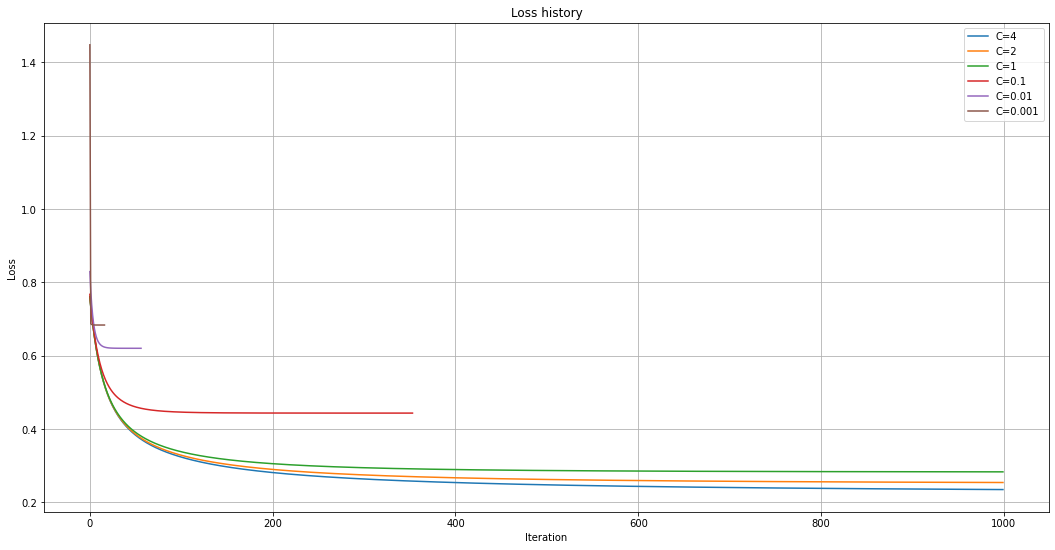

In [23]:
С_rates = [4, 2, 1 , 0.1, 0.01, 0.001]
models = [CustomLogisticRegression(C=cr) for cr in С_rates]
for model in models:
    model.fit(X_train, y_train)
plot_loss_graph_с(models)


При малых значениях С количество итераций сокращается из-за срабатывания по условию прерывания цикла. Тоесть delta становиться меньше tol, хотя вроде бы С находится в знаменателе одного из слогаемых и delta должна быть большой. Получаетя в описании переменных к классу ошибка или они имели ввиду 1/С. Посмотрим на точность крайних моделей.

C:\Users\slobbery.GBAS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


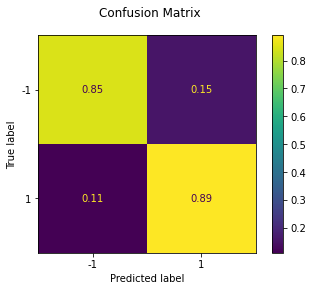

(0.837160751565762, 0.8694444444444445)

In [24]:
train_acc, test_acc = fit_evaluate(CustomLogisticRegression(
    C=0.001), X_train, y_train, X_test, y_test)
train_acc, test_acc


C:\Users\slobbery.GBAS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


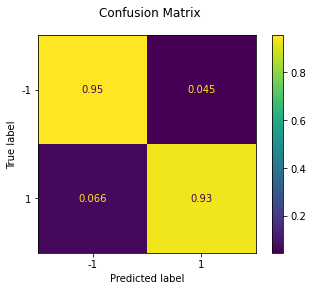

(0.9151009046624913, 0.9444444444444444)

In [25]:
train_acc, test_acc = fit_evaluate(CustomLogisticRegression(
    C=4), X_train, y_train, X_test, y_test)
train_acc, test_acc


Получается что при увеличение С увеличивается точность модели.

**(0.5 points)** Compare zero initialization and random initialization. 

Из анализа предыдущих графиков зафиксируем eta = 0.001, С поставим 4, так как при этом значении Loss наискорейшим образом достигает минимума в пределах заданных ограничений в 1000 циклов. И построим два графика с и без инициализации нулями первичных весов.

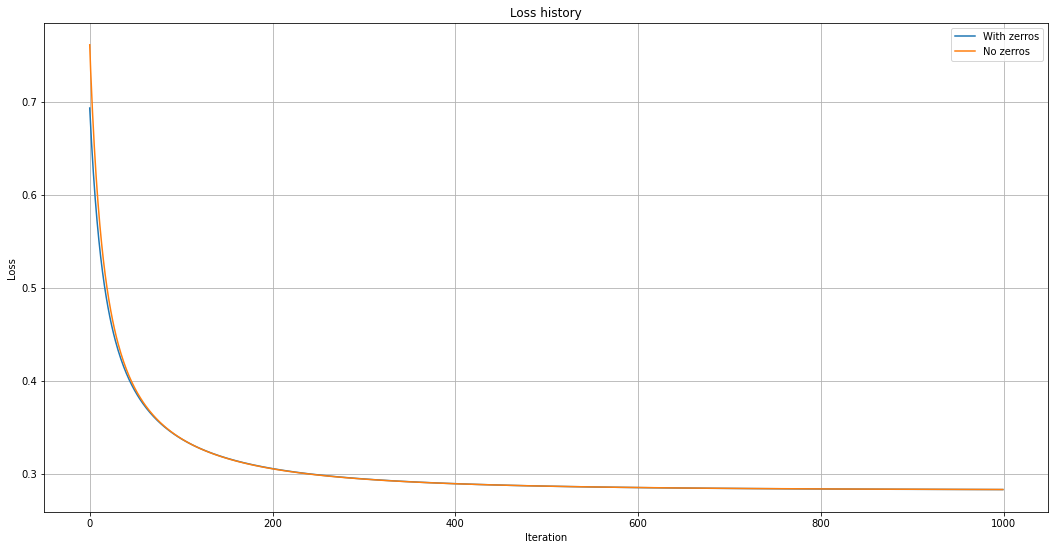

In [26]:
model_zerro = CustomLogisticRegression(zero_init=True)
model_non_zerro = CustomLogisticRegression()
model_zerro.fit(X_train, y_train)
model_non_zerro.fit(X_train, y_train)
plt.figure(figsize=(18, 9))
plt.plot(range(len(model_zerro.loss_history)),
         model_zerro.loss_history, label=f'With zerros')
plt.plot(range(len(model_non_zerro.loss_history)),
         model_non_zerro.loss_history, label=f'No zerros')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


C:\Users\slobbery.GBAS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


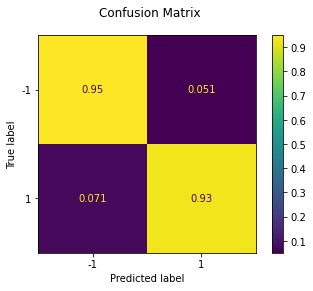

(0.9116214335421016, 0.9388888888888889)

In [27]:
train_acc, test_acc = fit_evaluate(CustomLogisticRegression(zero_init=True), X_train, y_train, X_test, y_test)
train_acc, test_acc


Так как мы в loss функции используем L2 то в нашем случае факт инициализации нулями сильно не влияет на результат нахождения весов, ввиду наличия одного минимума для функции loss. мы влюбом случае к нему придем вопрос в количестве итераций. Например из графика выше видно что инициализация нулями позволила получить модель с лучшей точностью за 1000 шагов. Просто мы расположили начальную точку отсчета более ближе к минимуму. Но если мы сейчасувеличим количество до 2000 шагов результат с ненулевой инициализацией будет такой же. 

C:\Users\slobbery.GBAS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


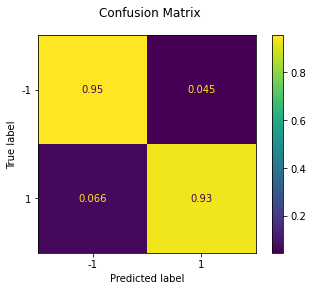

(0.9144050104384134, 0.9444444444444444)

In [28]:
train_acc, test_acc = fit_evaluate(CustomLogisticRegression(max_iter=2000), X_train, y_train, X_test, y_test)
train_acc, test_acc


Ну вот что и следовало ожидать.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [29]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P= np.zeros((X.shape[0], Y.shape[0]))
        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                P[i][j] = np.linalg.norm(X[i]-Y[j])
        return P
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        if not hasattr(self, 'classes_'):
            self.classes_ = np.unique(y)
        return [np.sum(weights[y == yi]) for yi in self.classes_]
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)

        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        y = np.zeros((X.shape[0], self.classes_.shape[0]))
        def f(x): return 1/(x + self.eps)
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = f(P)
                for i in range(y.shape[0]):
                    indexes = weights_of_points[i].argsort()[-self.n_neighbors:]
                    classes = self.y[indexes]
                    weights = weights_of_points[i][indexes]
                    y[i] = self.get_class_weights(classes, weights)/weights.sum()
            else:
                for i in range(y.shape[0]):
                    indexes = P[i].argsort()[:self.n_neighbors]
                    classes = self.y[indexes]
                    weights = weights_of_points[i][indexes]
                    y[i] = self.get_class_weights(classes, weights)/weights.sum()
            return y
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        Z = self.predict_proba(X)
        return np.array([self.classes_[Z[i].argmax()] for i in range(Z.shape[0])])



In [30]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [31]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [32]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

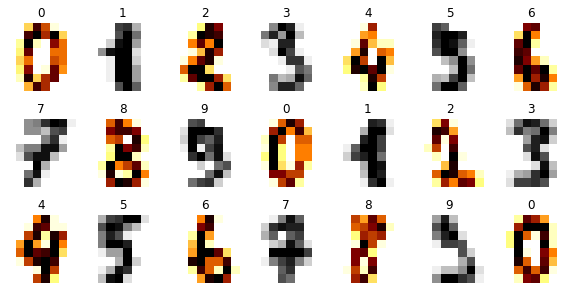

In [33]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [34]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [35]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

C:\Users\slobbery.GBAS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


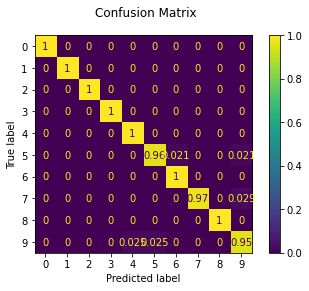

In [36]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [37]:
train_acc, test_acc


(1.0, 0.9861111111111112)

In [38]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Из матрицы видно что путает 5 с 6 и 9, 7 с 9, 9 с 4 и 5. Путает потому что похоже написание. Не понятно почему 7 с 9 путает, наверное маленький набор и не совсем чистые картинки.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

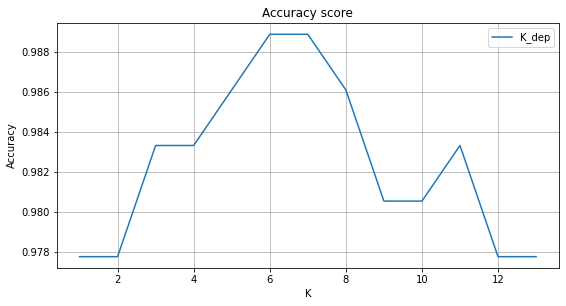

In [45]:
def plot_accuracy_score(k_arr, xlabel='K', ylabel='Accuracy', title='Accuracy score'):
    plt.figure(figsize=(9, 4.5))
    accuracy_score_arr = []
    for i in k_arr:
        model_ = CustomKNeighborsClassifier(n_neighbors=i, weights='distance')
        model_.fit(X_train, y_train)
        accuracy_score_arr.append(metrics.accuracy_score(y_pred=model_.predict(X_test), y_true=y_test))
    plt.plot(k_arr,accuracy_score_arr, label=f'K_dep')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

plot_accuracy_score(list(range(1, 14)))

Из графика получаем что оптимальное количество соседних точек равно 6,7 для имеющихся исходных данны. По обе стороны от этого числа точность падает из-за увеличения влияния шумовых точек (это когда на тренировочной картинке изображение цифры все больше расплывается и получается области пикселей перекрываются) 

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

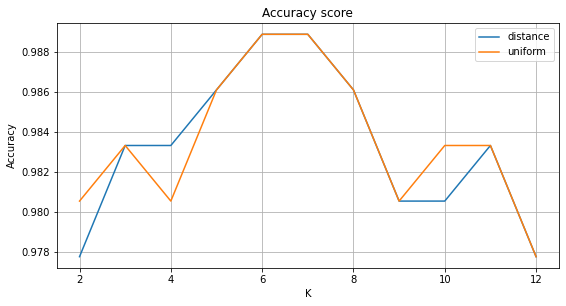

In [51]:

def plot_accuracy_score_w(k_arr, xlabel='K', ylabel='Accuracy', title='Accuracy score'):
    plt.figure(figsize=(9, 4.5))
    accuracy_score_arr_distance = []
    for i in k_arr:
        model_ = CustomKNeighborsClassifier(n_neighbors=i, weights='distance')
        model_.fit(X_train, y_train)
        accuracy_score_arr_distance.append(metrics.accuracy_score(y_pred=model_.predict(X_test), y_true=y_test))
    plt.plot(k_arr,accuracy_score_arr_distance, label=f'distance')
    
    accuracy_score_arr_uniform = []
    for i in k_arr:
        model_ = CustomKNeighborsClassifier(n_neighbors=i)
        model_.fit(X_train, y_train)
        accuracy_score_arr_uniform.append(metrics.accuracy_score(y_pred=model_.predict(X_test), y_true=y_test))
    plt.plot(k_arr,accuracy_score_arr_uniform, label=f'uniform')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

plot_accuracy_score_w(list(range(2, 13)))

В моем понимании использование весов обратных расстоянию более эфективно на разреженных данных когда значение расстояния действительно имеет значение. Если точки классов имеют малый разброс то веса от растояния можно невводить а считать только по максимуму какого-то класса.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Как вариант можно пробовать строить деревья к уже найденным соседям и таким образом отсеивать опорные точки которые являются случайными в данной области. Больше идей нет

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Для улучшения качества иходных данных можно попытаться прогнать через фильтр изображения цифр что бы они стали более "чище". 

## Part 3: Synthetic Titanic Survival Prediction

НЕ ДЕЛАЛ
